## Import a Data Frame

In [1]:
import os
import pathlib
import sys


library_tools_path = str(pathlib.PurePath(os.getcwd()))
sys.path.append(library_tools_path)

import Library_Portfolio_Tools as lpt

In [2]:
# Main

# Global Variables
closing_date = "2023-06-12"

path_portfolio = library_tools_path + '/Data_Set_Closing.xlsx'
eligibility_check = lpt.bank_eligibility_check(path_portfolio, 
                                               ADVANCE_RATE=65, 
                                               closing_date=closing_date)

eligibility_check["Covenants"]

{'4.a) Manufactured by an Acceptable Manufacturer': 'No Manufacturer breaches have been observed',
 '4.b) NBV Weighted Average Age of such Equipment': 'No NBV weighted average age breach',
 '4.c) Average Remaining Lease Term of the such Equipment manufactured after 2019': 'No Containers Manufactured after 2019 remaining lease term breaches (Avg Remaing Lease Term 2,451.16 years)',
 '4.d) Total Purchase Price by CEU': 'No NBV by CEU breach: 1,650.02 USD. The limit is 2900 USD',
 '5.19) Concentration Limits': 'No concentration convenant breach',
 'Advance Rate cheking': 'No Advance Rate breaches (Advance Rate 60.30%)',
 '5.13) OFF Lease portfolio NBV concentration': 'No Off lease proportion breaches (Proportion 3.83%)',
 '5.17) Finance Lease portfolio NBV concentration': 'No Finance lease proportion breaches (Proportion 2.19%)'}

In [3]:
eligibility_check["Covenants"]

{'4.a) Manufactured by an Acceptable Manufacturer': 'No Manufacturer breaches have been observed',
 '4.b) NBV Weighted Average Age of such Equipment': 'No NBV weighted average age breach',
 '4.c) Average Remaining Lease Term of the such Equipment manufactured after 2019': 'No Containers Manufactured after 2019 remaining lease term breaches (Avg Remaing Lease Term 2,451.16 years)',
 '4.d) Total Purchase Price by CEU': 'No NBV by CEU breach: 1,650.02 USD. The limit is 2900 USD',
 '5.19) Concentration Limits': 'No concentration convenant breach',
 'Advance Rate cheking': 'No Advance Rate breaches (Advance Rate 60.30%)',
 '5.13) OFF Lease portfolio NBV concentration': 'No Off lease proportion breaches (Proportion 3.83%)',
 '5.17) Finance Lease portfolio NBV concentration': 'No Finance lease proportion breaches (Proportion 2.19%)'}

In [4]:
# Hedge Calculation
lpt.calculate_hedge_payment(path_portfolio, NOTIONAL=17000000, NUM_PAYMENTS=59)

{'Hedge': 4259715.940376819}

In [5]:
# NPV and ROI at T=0
lpt.cashflow_calculation(path_portfolio,
                         0.003,  # Insurance Fees
                         0.007,  # Agency Fees
                         0.002,  # Handling Fees
                         0.005,  # Bad debt
                         17000000, # NOTIONAL
                         59, # Nb of Quarters
                         0.01794847,  # Discount Rate
                         0.06 # Per Diem Evolution
                         ) ['NPV']

21379676.384862363

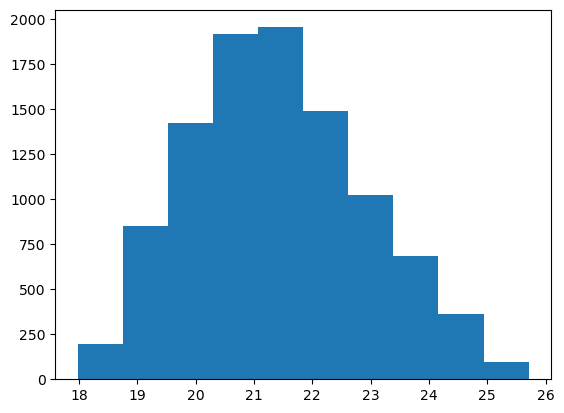

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# Sensitivity Analysis

NPV_values = np.array([])
for i in range(10000):
    NPV_values = np.append(NPV_values, (lpt.cashflow_calculation(path_portfolio,
                                                                 0.003,  # Insurance Fees
                                                                 0.007,  # Agency Fees
                                                                 0.002,  # Handling Fees
                                                                 0.005,  # Bad debt
                                                                 17000000,
                                                                 59,
                                                                 np.random.triangular(left=0.005, mode=0.01794847, right=0.03, size=1), # WACC
                                                                 np.random.triangular(left=-0.1, mode=0.06, right=0.1, size=1), # PD evol
                                                                 np.random.triangular(left=-0.03, mode=0.01, right=0.03) # RV evol
                                                                 )['NPV']))

plt.hist(np.array(NPV_values)/1000000)
plt.show()
